In [2]:
import requests
import json
import time
from datetime import date
from datetime import datetime
from helpers.history_fetcher import HistoryFetcher
import dateutil.parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdelt # pip install gdelt
import folium
import os
from tqdm import tqdm_notebook # conda install tqdm
import operator
from helpers.wiki_helpers import get_stability_for_country, make_folium_map, wiki_change_factor

import warnings
warnings.filterwarnings('ignore')

import itertools

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
### Introduction

Our project idea came from the observation that some wikipedia pages seems to get updated a lot after a related events happens. This could be observed during the Catalonia crisis that happened in september-october 2017, Ukraine War in Donbass and many others. We then wondered how we could exploit this information and quickly agreed that those changes could be correlated to a country's stability. Therefore, the project aims to build a stability index for countries using wikipedia data.

#### Maps info
There are folium maps in this notebook. If youre viewing in on Github, open it here to see the maps:<br>
https://nbviewer.jupyter.org/github/Amaumaury/ada-2017/blob/master/project/Milestone2.ipynb


#### Part 1

The first step for our project was then to find evidence of the correlation between events and edits on wikipedia. To tackle this problem we decided to take a special case: the 2014 Ukraine war. Our approach is to show a visual argument (plot) that confirms our intuition.

#### Part 2

Knowing that the causility between events and wikipedia edits existed, we then decided to make a first prototype of our stability index. 

#### Part 3

In this part, we showed the limit of our approach. This let us make a plan for the next milestone

#### Part 4

This part exposes our plan for the next milestone.




---
### Part I - Finding evidence of the implication: main events => lots of wikipedia edits

#### 1 - Find a dataset that contains events for the Ukraine war. 

Intialy we selected the UCDP GED dataset. Unfortunately, as this dataset contains only armed events, we were not able able to find a good visual argument for our intuition. We thus decided to switch to a richer dataset: GDELT events. In order to handle the data, we used a library called **gdeltPyR**.

In [36]:
type(results)

pandas.core.frame.DataFrame

In [33]:
# Initialize our GDELT fetcher and fetch data
gd1 = gdelt.gdelt(version=1)
results = gd1.Search(['2014 February 01','2014 April 30'],table='events')
cols_to_keep = ['SQLDATE','ActionGeo_CountryCode','ActionGeo_ADM1Code', 'ActionGeo_Type' ]
results = results[cols_to_keep]
pd.to_pickle(results, 'gdelt_filtered.pckl')

In [14]:
# Select events related to Ukraine
ukraine_events = results[results['ActionGeo_CountryCode'] == 'UP']

# Properly format the date for each event
ukraine_events['SQLDATE'] = ukraine_events['SQLDATE'].map(lambda d: pd.Timestamp(str(d)))
ukraine_events = ukraine_events.set_index('SQLDATE')

# Filter out events that are out of our timeframe
ukraine_events = ukraine_events.loc[ukraine_events.index >= pd.Timestamp('20140201')]
ukraine_events = ukraine_events.loc[ukraine_events.index <= pd.Timestamp('20140430')]

# Final holder for our events
ukraine_events_dates = list(ukraine_events.index)

In [32]:
fr_events = results[ (results['ActionGeo_CountryCode'] == 'FR') & (results['ActionGeo_ADM1Code'] == 'FR')]
fr_events['SQLDATE'] = fr_events['SQLDATE'].map(lambda d: pd.Timestamp(str(d)))
fr_events = fr_events.set_index('SQLDATE')

# Filter out events that are out of our timeframe
fr_events = ukraine_events.loc[ukraine_events.index >= pd.Timestamp('20140201')]
fr_events = ukraine_events.loc[ukraine_events.index <= pd.Timestamp('20140430')]

fr_events_dates = list(fr_events.index)
fr_events

,GLOBALEVENTID,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,Actor1Religion1Code,...,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
SQLDATE,,,,,,,,,,,,,,,,,,,,,
2014-02-03,284604151,201402,2014,2014.0904,GOV,ADMINISTRATION,NaN,NaN,NaN,NaN,...,-1046268,4,"Maydan, Zakarpats'ka Oblast', Ukraine",UP,UP25,48.6031,23.4741,-1046268,20140204,"UNIAN news agency, Kiev/BBC Monitoring/(c) BBC"
2014-02-03,284604173,201402,2014,2014.0904,GOV,PRESIDENT,NaN,NaN,NaN,NaN,...,-1044367,4,"Kiev, Ukraine (general), Ukraine",UP,UP00,50.4333,30.5167,-1044367,20140204,http://www.scotsman.com/news/world/poll-plan-t...
2014-02-03,284604174,201402,2014,2014.0904,GOV,ADMINISTRATION,NaN,NaN,NaN,NaN,...,-1046268,4,"Maydan, Zakarpats'ka Oblast', Ukraine",UP,UP25,48.6031,23.4741,-1046268,20140204,"UNIAN news agency, Kiev/BBC Monitoring/(c) BBC"
2014-02-03,284604372,201402,2014,2014.0904,LEG,PARLIAMENT,NaN,NaN,NaN,NaN,...,-1044367,4,"Kiev, Ukraine (general), Ukraine",UP,UP00,50.4333,30.5167,-1044367,20140204,http://www.themalaysianinsider.com/world/artic...
2014-02-03,284604392,201402,2014,2014.0904,MCOELI,ALBERT,MCO,NaN,NaN,NaN,...,-1046268,4,"Maydan, Zakarpats'ka Oblast', Ukraine",UP,UP25,48.6031,23.4741,-1046268,20140204,"UNIAN news agency, Kiev/BBC Monitoring/(c) BBC"
2014-02-03,284604552,201402,2014,2014.0904,OPP,THE OPPOSITION,NaN,NaN,NaN,NaN,...,-1044367,4,"Kiev, Ukraine (general), Ukraine",UP,UP00,50.4333,30.5167,-1044367,20140204,http://www.gulf-times.com/UK-Europe/183/detail...
2014-02-03,284604554,201402,2014,2014.0904,OPP,ACTIVIST,NaN,NaN,NaN,NaN,...,-1046268,4,"Maydan, Zakarpats'ka Oblast', Ukraine",UP,UP25,48.6031,23.4741,-1046268,20140204,"UNIAN news agency, Kiev/BBC Monitoring/(c) BBC"
2014-02-03,284604710,201402,2014,2014.0904,UKR,UKRAINE,UKR,NaN,NaN,NaN,...,-1044367,4,"Kiev, Ukraine (general), Ukraine",UP,UP00,50.4333,30.5167,-1044367,20140204,http://www.scotsman.com/news/world/poll-plan-t...
2014-02-03,284604711,201402,2014,2014.0904,UKR,UKRAINE,UKR,NaN,NaN,NaN,...,-1044367,4,"Kiev, Ukraine (general), Ukraine",UP,UP00,50.4333,30.5167,-1044367,20140204,"UNIAN news agency, Kiev/BBC Monitoring/(c) BBC"


In [49]:
# Fetches Ukraine's wikipedia page history
history_fetcher = HistoryFetcher('France')
response = history_fetcher.get_history('20110201000000', '20170430000000')

# Keeps only the date field for each edit
fr_edits_dates = list(map(lambda revision: revision['timestamp'], response))

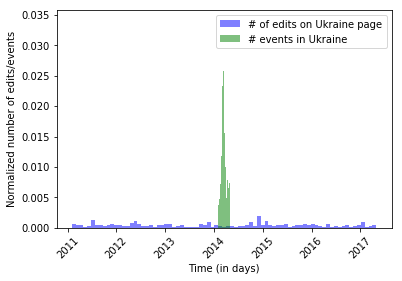

In [50]:
# Add historgram for the number of edits on ukraine's wikipedia page (normalized)
n_wiki, bins_wiki, patches_wiki = plt.hist(fr_edits_dates,\
                                           bins=79,\
                                           normed=True,\
                                           color='blue',\
                                           alpha=0.5,\
                                           label='# of edits on Ukraine page')

# Add histogram for the number of events (normalized)
n_event, bins_event, patches_event = plt.hist(fr_events_dates,\
                                              bins=79,\
                                              color='green',\
                                              normed=True,\
                                              alpha=0.5,\
                                              label='# events in Ukraine')

plt.xticks(rotation=45)
plt.xlabel('Time (in days)')
plt.ylabel('Normalized number of edits/events')
plt.legend(loc='upper right')
plt.show()

We decided to select only events that occured between 02.01.2014 and 04.30.2014 as this timeframe bounds the beginning of the war.

#### 2 - Grab the history (i.e. edits) of Ukraine's wikipedia page.

In order to grab the edits history for any wikipedia page, we used wikipedia's API and proxied it through our HistoryFetcher class. 

In [2]:
# Fetches Ukraine's wikipedia page history
history_fetcher = HistoryFetcher('Ukraine')
response = history_fetcher.get_history('20140201000000', '20140430000000')

# Keeps only the date field for each edit
ukraine_edits_dates = list(map(lambda revision: revision['timestamp'], response))

#### 3 - Plot the number of edits and events over time

This task was done ploting simple histograms with matplotlib. Both curve are normalized for visibility purposes. 

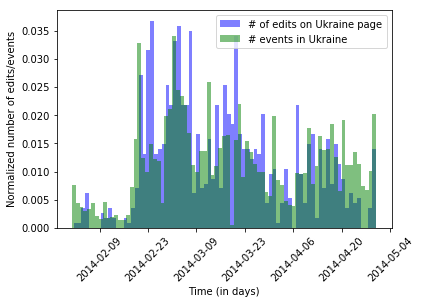

In [51]:
# Add historgram for the number of edits on ukraine's wikipedia page (normalized)
n_wiki, bins_wiki, patches_wiki = plt.hist(ukraine_edits_dates,\
                                           bins=79,\
                                           normed=True,\
                                           color='blue',\
                                           alpha=0.5,\
                                           label='# of edits on Ukraine page')

# Add histogram for the number of events (normalized)
n_event, bins_event, patches_event = plt.hist(ukraine_events_dates,\
                                              bins=79,\
                                              color='green',\
                                              normed=True,\
                                              alpha=0.5,\
                                              label='# events in Ukraine')

plt.xticks(rotation=45)
plt.xlabel('Time (in days)')
plt.ylabel('Normalized number of edits/events')
plt.legend(loc='upper right')
plt.show()

In [17]:
print('Pearson coefficient for our two normalized series is:', np.corrcoef(n_wiki, n_event)[1, 0], '\nThis is a rather high value that emphasize our intuition.')

Pearson coefficient for our two normalized series is: 0.646269617313 
This is a rather high value that emphasize our intuition.


In [3]:
aggregated_gdelt = pd.read_pickle( 'data/aggregated_gdelt.pckl')
aggregated_gdelt.head(20)

def get_country_values(cntr_code, normalize=True):
    values_to_plot = aggregated_gdelt[ (aggregated_gdelt['ActionGeo_CountryCode'] == cntr_code)];
    values_to_plot['ActionGeo_Type'] = 0;
    values_to_plot.groupby(['SQLDATE','ActionGeo_CountryCode', 'ActionGeo_Type']).sum()
    values_to_plot.reset_index(inplace=True)
    if(normalize):
        x = values_to_plot['SQLDATE']
        y = values_to_plot['Counter']/ values_to_plot['Counter'].mean()
    else:
        x = values_to_plot['SQLDATE']
        y = values_to_plot['Counter']
    return x.values,y.values


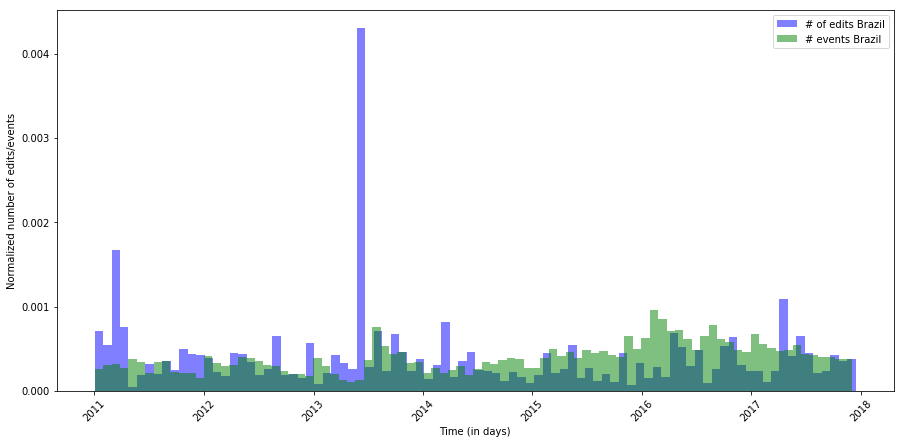

In [4]:

# Fetches Ukraine's wikipedia page history
history_fetcher = HistoryFetcher('Brazil')
response = history_fetcher.get_history('20110101000000', '20171215000000')

# Keeps only the date field for each edit
fr_edits_dates = list(map(lambda revision: revision['timestamp'], response))

plt.figure(figsize=(15,7))

# Add historgram for the number of edits on ukraine's wikipedia page (normalized)
n_wiki, bins_wiki, patches_wiki = plt.hist(fr_edits_dates,\
                                           bins=90,\
                                           normed=True,\
                                           color='blue',\
                                           alpha=0.5,\
                                           label='# of edits Brazil')

fr_events_dates, w = get_country_values('BR')
# Add histogram for the number of events (normalized)s
n_event, bins_event, patches_event = plt.hist(fr_events_dates,\
                                              weights=w,
                                              bins=90,\
                                              color='green',\
                                              normed=True,\
                                              alpha=0.5,\
                                              label='# events Brazil')

plt.xticks(rotation=45)
plt.xlabel('Time (in days)')
plt.ylabel('Normalized number of edits/events')
plt.legend(loc='upper right')
plt.show()

In [ ]:

# Fetches Ukraine's wikipedia page history
history_fetcher = HistoryFetcher('France')
response = history_fetcher.get_history('20110101000000', '20171215000000')

# Keeps only the date field for each edit
fr_edits_dates = list(map(lambda revision: revision['timestamp'], response))

plt.figure(figsize=(15,7))

# Add historgram for the number of edits on ukraine's wikipedia page (normalized)
n_wiki, bins_wiki, patches_wiki = plt.hist(fr_edits_dates,\
                                           bins=90,\
                                           normed=True,\
                                           color='blue',\
                                           alpha=0.5,\
                                           label='# of edits France')

fr_events_dates, w = get_country_values('FR')
# Add histogram for the number of events (normalized)s
n_event, bins_event, patches_event = plt.hist(fr_events_dates,\
                                              weights=w,
                                              bins=90,\
                                              color='green',\
                                              normed=True,\
                                              alpha=0.5,\
                                              label='# events France')

plt.xticks(rotation=45)
plt.xlabel('Time (in days)')
plt.ylabel('Normalized number of edits/events')
plt.legend(loc='upper right')
plt.show()

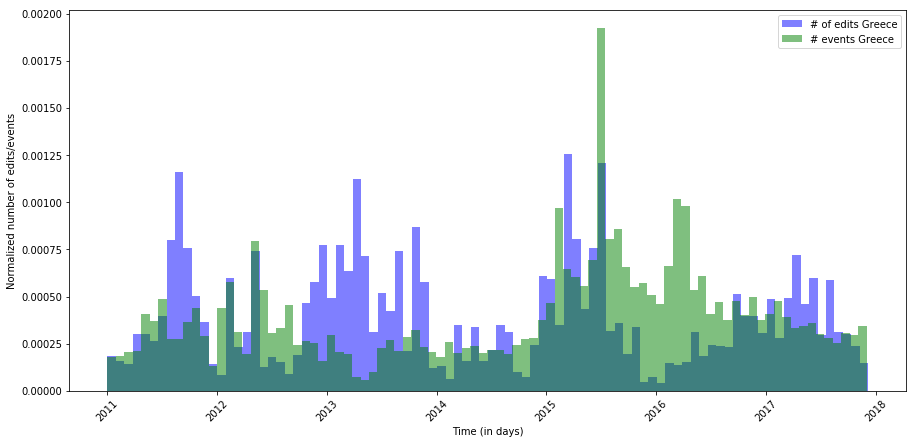

In [71]:

# Fetches Ukraine's wikipedia page history
history_fetcher = HistoryFetcher('Greece')
response = history_fetcher.get_history('20110101000000', '20171215000000')

# Keeps only the date field for each edit
fr_edits_dates = list(map(lambda revision: revision['timestamp'], response))

plt.figure(figsize=(15,7))

# Add historgram for the number of edits on ukraine's wikipedia page (normalized)
n_wiki, bins_wiki, patches_wiki = plt.hist(fr_edits_dates,\
                                           bins=90,\
                                           normed=True,\
                                           color='blue',\
                                           alpha=0.5,\
                                           label='# of edits Greece')

fr_events_dates, w = get_country_values('GR')
# Add histogram for the number of events (normalized)s
n_event, bins_event, patches_event = plt.hist(fr_events_dates,\
                                              weights=w,
                                              bins=90,\
                                              color='green',\
                                              normed=True,\
                                              alpha=0.5,\
                                              label='# events Greece')

plt.xticks(rotation=45)
plt.xlabel('Time (in days)')
plt.ylabel('Normalized number of edits/events')
plt.legend(loc='upper right')
plt.show()

#### Conclusions

This initial investigation, by combining data from two sources, provides arguments towards the causality between events and edits on wikipedia. 

---
### Part II - A prototype for our countries' stability index

With this part we're trying to analyse the rate of wikipedia changes to estimate the stability of the country and its other factors. We believe this analysis is interesting and could draw very interesting conclusions and could also help to find events that causw wikipedia change.

#### Analyzing dynamism of Wikipedia changes

We designed a simple classifier function ( $wiki\_change\_factor(...)$ ) to show how many time wikipedia content varies in time fo a given wikipedia page. Our classifier is based on the mean of the wikipedia changes. If for some month there are number of changes that vary from the mean value too much (more than outlier_factor * mean), we mark this event as "out of normal behaviour" and at the end we sum these events and divide by the whole number of wiki changes for the period.

In [ ]:
inst_uk = wiki_change_factor('Ukraine', 2011, outlier_factor=3.4, plot_on=True)
print('Wikipedia Instability for Ukraine :', inst_uk)

In [ ]:


inst_nr = wiki_change_factor('Norway', 2011, outlier_factor=3.4, plot_on=True)
print('Wikipedia Instability for Norway :', inst_nr)

As we can see above, our classifier is able to detect major events in wikipedia changes and assign a numerical
value to the countries wikipedia stability.

#### Plans:
We're planning to test different classifiers based on derivation to detect different typed of peaks in the data in a different, more error-prone way.

<br>
#### Comparing European Countries
By plotting this coefficient values for different countries in Europe, we can plot a Map with different Wikipedia dynamism rate 

In [ ]:
countries = ['Ukraine','Poland','Spain', 'Netherlands','France','Germany','Switzerland','Belgium',
            'Portugal','Italy','Great Britain', 'Ireland', 'Norway', 'Sweden','Denmark',
            'Slovakia','Czech Republic','Austria','Hungary','Croatia','Romania','Greece','Serbia',
            'Macedonia','Albania','Estonia','Latvia','Finland','Lithuania','Russia','Bulgaria','Moldova',
            'Belarus','Turkey','Iceland']

codes = ['UA','PL','ES', 'NL','FR','DE','CH','BE', 'PT','IT','GB','IE','NO','SE','DK',
        'SK','CZ','AT','HU','HR','RO','GR','RS','MK','AL','EE','LV','FI','LT','RU','BG','MD',
        'BY','TR','IS']

wiki_change_values = {}

for i in tqdm_notebook(range(len(countries))):
    wiki_change_values[codes[i]] = wiki_change_factor(countries[i], 2011, outlier_factor = 3.4)

    
sorted_x = sorted(wiki_change_values.items(), key=lambda x: x[1])
values = np.zeros([len(sorted_x),1])
names = ['']*len(sorted_x)

for i in range(len(sorted_x)):
    names[i] = sorted_x[i][0]
    values[i] = sorted_x[i][1]
values= np.squeeze(values)

plt.rcParams["figure.figsize"] = (8,8)
plt.bar(range(len(sorted_x)), values, align='center')
plt.xticks(range(len(sorted_x)), names, rotation=45)
plt.ylabel('National Wikipedia Instability')
plt.title('Wikipedia instability by country (Europe)')
plt.show()

We could observe, that  as expected some very developed and stable countries have very stable wikipedia, and the less stable also less stable wikipedia. However we could observe some interesting facts for some nations:
- Ukraine has lots of instability due to war
- Germany or Croatia has a lot of instability in its wikipedia - to be discovered why, maybe there are some major events to be correlated
- The computed instability factor highly depends on computation method, therefore we should prove better that our method is valid.

#### Wikipedia Instability Map in Europe.
In this part we're showing on the map the previously computed values for Wikipedia Instabilities per country on tha map. 

In [ ]:
colors_eu = ['#ffe6d0', '#fcbba1', '#fc9272', '#fb6a4a', '#ef3b2c', '#cb181d', '#a50f15', '#89000d']
thresh_eu = [0.03      , 0.06      , 0.1      , 0.13     , 0.16     , 0.2     , 0.23     , 0.26]


def wiki_changes_colors_eu(state):
    """Maps Unemplpoyment value with colors."""
    try:
        val = wiki_change_values[state]
    except KeyError:
        return '#bdbdbd'
    
    if np.isnan(val):
        return '#bdbdbd'
    
    length = len(colors_eu)
    for i in range(0, length-1):
        if val < thresh_eu[i]:
            return colors_eu[i]
    return  colors_eu[length-1]


m = make_folium_map('data/europe2.topojson.json', 'objects.europe',
                    wiki_changes_colors_eu, 0.0, 0.259, colors_eu, 
                    [56,10], 3.5, '% Wiki page instability 2010-2017')

m

### Countries Analysis Worldwide

1. Load the % of people using internet for all countries database from the UN Data.
2. Load All number of people for all countries database from the UN Data.
3. Merge the 2 dataframes and compute the number of people using internet 
4. Load countries names in ISO-2 codes for the map

In [76]:
nr_internet_people = pd.read_csv('data/nr_people_internet.csv')
cols_to_keep = ['Country or Area','Value']
nr_internet_people = nr_internet_people[cols_to_keep]
nr_internet_people.columns=['Country','Internet Users%']
nr_internet_people.set_index('Country',inplace=True)

nr_all_people = pd.read_csv('data/nr_people_all.csv')
nr_all_people = nr_all_people[nr_all_people['Variant']=='Medium'][cols_to_keep]
cols_to_keep = ['Country or Area','Value']
nr_all_people = nr_all_people[cols_to_keep]
nr_all_people.columns=['Country','Population[k]']
nr_all_people.set_index('Country',inplace=True)


population_data = pd.concat([nr_all_people, nr_internet_people], axis=1, join='inner')
population_data['Internet users[k]'] = population_data['Population[k]'] * population_data['Internet Users%']/100
population_data.head(5)


countries_data = pd.read_csv('data/country-codes.csv')[1:]
cols_to_keep = ['official_name_en','ISO3166-1-Alpha-3','ISO3166-1-Alpha-2' ,'Least Developed Countries (LDC)','Region Name',
                'Small Island Developing States (SIDS)', 'is_independent']
countries_data = countries_data[cols_to_keep]

# selectbonly independent countires
#countries_data = countries_data[countries_data['is_independent']=='Yes']

#countries_data = countries_data[countries_data['Least Developed Countries (LDC)']!='x']
#countries_data = countries_data[countries_data['Small Island Developing States (SIDS)']!='x']

cols_to_keep = ['official_name_en','ISO3166-1-Alpha-3','ISO3166-1-Alpha-2' ,'Region Name']

countries_data = countries_data[cols_to_keep]
countries_data.columns = ['Country', 'Code','Code2','Region']
countries_data['Wiki Stability MLE'] = np.NaN;
countries_data['Wiki Instability old'] = np.NaN;
countries_data['Wiki mean change day'] = np.NaN;
countries_data.set_index('Country',inplace=True)


countries_data = pd.concat([countries_data, population_data], axis=1, join='inner')
countries_data['Big Internet'] = countries_data['Internet users[k]'] > 1000
countries_data.reset_index(inplace=True)

gdp_data = pd.read_csv('data/UNdata_GDP.csv')
keep_cols = ['Country or Area', 'Value']

gdp_data = gdp_data[keep_cols]
gdp_data.columns = ['Country', 'GDP']
gdp_data.set_index('Country', inplace=True)
#countries_data.reset_index(inplace=True)
countries_data.set_index('Country', inplace=True)
countries_data = pd.concat([countries_data, gdp_data], axis=1, join='inner')
countries_data.reset_index(inplace=True)

countries_data['GDP per capita'] = countries_data['GDP'] / countries_data['Population[k]']

countries_data.head()

,Country,Code,Code2,Region,Wiki Stability MLE,Wiki Instability old,Wiki mean change day,Population[k],Internet Users%,Internet users[k],Big Internet,GDP,GDP per capita
0,Afghanistan,AFG,AF,Asia,NaN,NaN,NaN,35530.081,8.260000,2934.784691,True,623.184798,0.017540
1,Albania,ALB,AL,Europe,NaN,NaN,NaN,2930.187,63.252933,1853.429211,True,3984.234302,1.359720
2,Algeria,DZA,DZ,Africa,NaN,NaN,NaN,41318.142,38.200000,15783.530244,True,4154.118319,0.100540
3,Andorra,AND,AD,Europe,NaN,NaN,NaN,76.965,96.910000,74.586782,False,39896.376936,518.370388
4,Angola,AGO,AO,Africa,NaN,NaN,NaN,29784.193,12.400000,3693.239932,True,4714.065956,0.158274


In [3]:

# adding the countires that are missing in the map
import json

geo_data = json.load(open('data/countries.geo.json'))

keys=[k['id'] for k in geo_data['features']]
missing_keys=set(keys)-set(countries_data['Code'])

for k in (missing_keys):
    temp = pd.DataFrame([['', k,'',np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN, np.NaN]], columns=countries_data.columns)
    countries_data = countries_data.append(temp, ignore_index=True)

countries_data.head(5)


,Country,Code,Region,Wiki Stability MLE,Wiki Instability old,Wiki mean change day,Population[k],Internet Users%,Internet users[k],Big Internet,GDP,GDP per capita
0,Afghanistan,AFG,Asia,NaN,NaN,NaN,35530.081,8.260000,2934.784691,1.0,623.184798,0.017540
1,Albania,ALB,Europe,NaN,NaN,NaN,2930.187,63.252933,1853.429211,1.0,3984.234302,1.359720
2,Algeria,DZA,Africa,NaN,NaN,NaN,41318.142,38.200000,15783.530244,1.0,4154.118319,0.100540
3,Andorra,AND,Europe,NaN,NaN,NaN,76.965,96.910000,74.586782,0.0,39896.376936,518.370388
4,Angola,AGO,Africa,NaN,NaN,NaN,29784.193,12.400000,3693.239932,1.0,4714.065956,0.158274


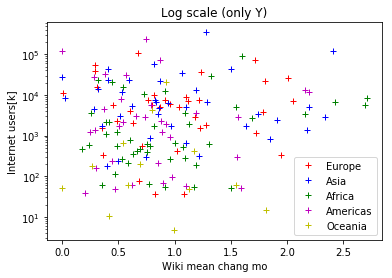

In [6]:
#countries_data = pd.read_pickle('countries_data.pkl')
changes_europe = countries_data[countries_data['Region'] == 'Europe']['Wiki mean change day'].values
people_europe = countries_data[countries_data['Region'] == 'Europe']['Internet users[k]'].values
changes_asia = countries_data[countries_data['Region'] == 'Asia']['Wiki mean change day'].values
people_asia = countries_data[countries_data['Region'] == 'Asia']['Internet users[k]'].values
changes_africa = countries_data[countries_data['Region'] == 'Africa']['Wiki mean change day'].values
people_africa = countries_data[countries_data['Region'] == 'Africa']['Internet users[k]'].values

changes_americas = countries_data[countries_data['Region'] == 'Americas']['Wiki mean change day'].values
people_americas = countries_data[countries_data['Region'] == 'Americas']['Internet users[k]'].values

changes_oceania = countries_data[countries_data['Region'] == 'Oceania']['Wiki mean change day'].values
people_oceania = countries_data[countries_data['Region'] == 'Oceania']['Internet users[k]'].values

plt.semilogy(changes_europe,people_europe,'+r')
plt.hold(True)
plt.semilogy(changes_asia,people_asia,'+b')
plt.semilogy(changes_africa,people_africa,'+g')
plt.semilogy(changes_americas,people_americas,'+m')
plt.semilogy(changes_oceania,people_oceania,'+y')
plt.legend(['Europe','Asia','Africa','Americas','Oceania'])
plt.title('Log scale (only Y)')
plt.xlabel('Wiki mean chang mo')
plt.ylabel('Internet users[k]')
plt.show()

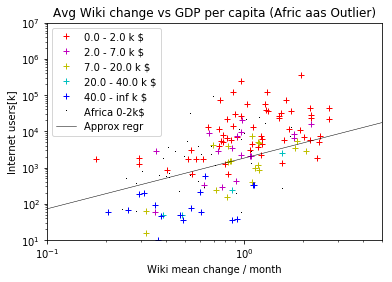

In [264]:
countries_data = pd.read_pickle('countries_data.pckl')


intervals =  np.append(0, np.append([ 2, 7, 20, 40], np.inf))
colors =     ['+r',  '+m', '+y' , '+c',    '+b',   '+k'];

plt.clf()
plt.hold(True)
for i in range(len(intervals)-1):
    changes = countries_data[countries_data['Region']!='Africa'][(countries_data['GDP per capita'] > intervals[i]) & (countries_data['GDP per capita'] <= intervals[i+1])]['Wiki mean change day'].values
    changes = np.squeeze(changes)
    people = countries_data[countries_data['Region']!='Africa'][(countries_data['GDP per capita'] > intervals[i]) & (countries_data['GDP per capita'] <= intervals[i+1])]['Internet users[k]'].values
    people = np.squeeze(people)
    plt.loglog(changes,people,colors[i])
    
# plotting only Africa outliers
changes = countries_data[countries_data['Region']=='Africa'][(countries_data['GDP per capita'] > 0) & (countries_data['GDP per capita'] <= intervals[1])]['Wiki mean change day'].values    
np.squeeze(changes)
people = countries_data[countries_data['Region']=='Africa'][(countries_data['GDP per capita'] > 0) & (countries_data['GDP per capita'] <= intervals[1])]['Internet users[k]'].values
people = np.squeeze(people)
plt.loglog(changes,people,',k')

a = 1.4
b = 1820
x = [1e-2,1e0, 5, 10]
y = np.power(x,a)*b

plt.loglog(x,y,'-k',linewidth=0.5)

val_str = []
for i, val in enumerate(intervals[1:]):
    val_str.append(str(intervals[i]) + ' - ' + str(val)+' k $')
val_str.append('Africa 0-2k$')
val_str.append('Approx regr')
plt.legend(val_str)
plt.title('Avg Wiki change vs GDP per capita (Afric aas Outlier)')
plt.xlabel('Wiki mean change / month')
plt.ylabel('Internet users[k]')
plt.xlim([1e-1, 5])
plt.ylim([1e1, 1e7])
plt.show()

In [182]:
# computed distance between the line y=ax +c and the point x, y
def distance_from_line(a,c,x,y):
    a = -a;
    c=-c;
    return (a*x + y +c)/np.sqrt(a*a + 1)

def truncate_names(arr_string, n):
    for i in range (len(arr_string)):
        arr_string[i] = arr_string[i][:n]
    return arr_string

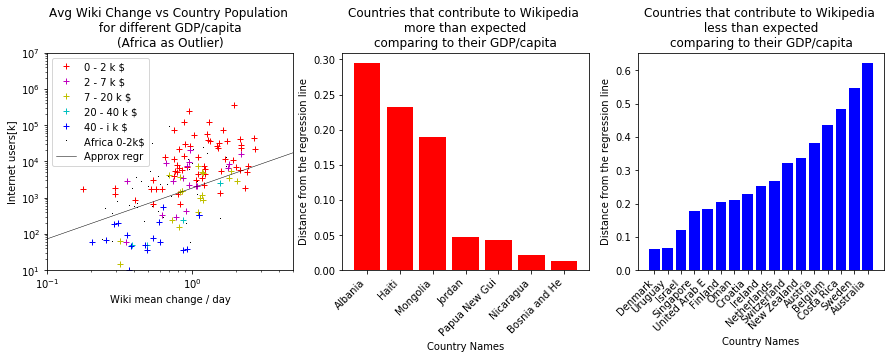

In [320]:
intervals =  np.append(0, np.append([ 2, 7, 20, 40], np.inf))
colors =     ['+r',  '+m', '+y' , '+c',    '+b',   '+k'];

plt.clf()
f = plt.subplot(1,3,1)
f.figure.set_figwidth(16)
plt.hold(True)
for i in range(len(intervals)-1):
    changes = countries_data[countries_data['Region']!='Africa'][(countries_data['GDP per capita'] > intervals[i]) & (countries_data['GDP per capita'] <= intervals[i+1])]['Wiki mean change day'].values
    changes = np.squeeze(changes)
    people = countries_data[countries_data['Region']!='Africa'][(countries_data['GDP per capita'] > intervals[i]) & (countries_data['GDP per capita'] <= intervals[i+1])]['Internet users[k]'].values
    people = np.squeeze(people)
    plt.loglog(changes,people,colors[i])
    
# plotting only Africa outliers
changes = countries_data[countries_data['Region']=='Africa'][(countries_data['GDP per capita'] > 0) & (countries_data['GDP per capita'] <= intervals[1])]['Wiki mean change day'].values    
np.squeeze(changes)
people = countries_data[countries_data['Region']=='Africa'][(countries_data['GDP per capita'] > 0) & (countries_data['GDP per capita'] <= intervals[1])]['Internet users[k]'].values
people = np.squeeze(people)
plt.loglog(changes,people,',k')

a = 1.4
b = 1820
x = [1e-2,1e0, 5, 10]
y = np.power(x,a)*b

plt.loglog(x,y,'-k',linewidth=0.5)

val_str = []
for i, val in enumerate(intervals[1:]):
    val_str.append(str(intervals[i])[:-2] + ' - ' + str(val)[:-2]+' k $')
val_str.append('Africa 0-2k$')
val_str.append('Approx regr')
plt.legend(val_str)
plt.title('Avg Wiki Change vs Country Population \n for different GDP/capita \n(Africa as Outlier)')
plt.xlabel('Wiki mean change / day')
plt.ylabel('Internet users[k]')
plt.xlim([1e-1, 5])
plt.ylim([1e1, 1e7])

changes_log = np.log10(countries_data[countries_data['Region']!='Africa'][(countries_data['GDP per capita'] <= 2.0)]['Wiki mean change day'])
people_log = np.log10(countries_data[countries_data['Region']!='Africa'][(countries_data['GDP per capita'] <= 2.0)]['Internet users[k]'])
distances = distance_from_line(a,np.log10(b),changes_log,people_log)
distances = distances[(~np.isnan(distances)) & ~np.isinf(distances)].sort_values()
# showing top10 countries that are down the line (active wikipedia) but are poor

df_topdown = distances[:7]
names_topdown = countries_data.ix[df_topdown.index.values]['Country'].values
names_topdown = truncate_names(names_topdown, 13)
values_topdown = -df_topdown.values

f = plt.subplot(1,3,2)
f.figure.set_figwidth(16)
plt.bar(range(len(names_topdown)), values_topdown, color="red")
plt.xticks(range(len(names_topdown)),names_topdown, rotation = 45 , ha='right')
plt.title('Countries that contribute to Wikipedia \n more than expected \ncomparing to their GDP/capita')
plt.xlabel('Country Names')
plt.ylabel('Distance from the regression line')


changes_log = np.log10(countries_data[countries_data['Region']!='Africa'][(countries_data['GDP per capita'] >= 2.0)][countries_data['Wiki mean change day'] > 0.1]['Wiki mean change day'])
people_log = np.log10(countries_data[countries_data['Region']!='Africa'][(countries_data['GDP per capita'] >= 2.0)][countries_data['Wiki mean change day'] > 0.1]['Internet users[k]'])
distances = distance_from_line(a,np.log10(b),changes_log,people_log)
distances = distances[(~np.isnan(distances)) & ~np.isinf(distances)].sort_values()
# showing top10 countries that are down the line (active wikipedia) but are poor

df_topup = distances[-17:]
names_topup = countries_data.ix[df_topup.index.values]['Country'].values
names_topup = truncate_names(names_topup, 13)
values_topup = df_topup.values

f = plt.subplot(1,3,3)
f.figure.set_figwidth(15)
plt.bar(range(len(names_topup)), values_topup, color="blue")
plt.xticks(range(len(names_topup)),names_topup, rotation = 45 , ha='right')
plt.title('Countries that contribute to Wikipedia \n less than expected \ncomparing to their GDP/capita')
plt.xlabel('Country Names')
plt.ylabel('Distance from the regression line')

plt.show()

array(['Slovenia', 'Panama', 'Latvia', 'Denmark', 'Uruguay', 'Israel',
       'Singapore', 'United Ara', 'Finland', 'Oman', 'Croatia', 'Ireland',
       'Netherland', 'Switzerlan', 'New Zealan', 'Austria', 'Belgium',
       'Costa Rica', 'Sweden', 'Australia'], dtype=object)

In [10]:
countries_data = pd.read_pickle('countries_data.pckl')
countries_data[( countries_data['Wiki Stability MLE'] > 3.0) | ( countries_data['Wiki mean change day'] < 0.30) ]

,Country,Code,Region,Wiki Stability MLE,Wiki Instability old,Wiki mean change day,Population[k],Internet Users%,Internet users[k],Big Internet,GDP,GDP per capita,stab to plot,Stability Truncated
0,Afghanistan,AFG,Asia,0.000000,0.000000,0.000000,35530.081,8.260000,2934.784691,1.0,623.184798,0.017540,0.000000,0.0
5,Antigua and Barbuda,ATG,Americas,3.303965,0.098758,0.257224,102.012,65.200000,66.511824,0.0,14764.489509,144.732870,0.949338,1.0
24,Brunei Darussalam,BRN,Asia,750.000000,NaN,0.001133,428.697,71.200000,305.232264,0.0,30552.659475,71.268657,NaN,1.0
36,Comoros,COM,Africa,3.006012,0.084367,0.282720,813.912,7.459161,60.711010,0.0,1368.853937,1.681821,0.956887,1.0
54,French Polynesia,PYF,Oceania,2.918288,0.023158,0.291218,283.007,64.560210,182.709913,0.0,18161.038940,64.171695,0.988353,1.0
55,Gabon,GAB,Africa,3.239741,0.000000,0.262323,2025.137,23.500000,475.907195,0.0,7960.715604,3.930952,1.000000,1.0
56,Georgia,GEO,Asia,4.792332,0.162791,0.177337,3912.061,45.158374,1766.623154,1.0,3491.436128,0.892480,0.914991,1.0
61,Grenada,GRD,Americas,4.189944,0.210909,0.202833,107.825,53.810000,58.020633,0.0,8933.809748,82.854716,0.888308,1.0
64,Guinea-Bissau,GNB,Africa,3.554502,0.200758,0.239093,1861.283,3.540707,65.902576,0.0,530.040454,0.284772,0.894004,1.0
67,Honduras,HND,Americas,2.901354,0.388995,0.292918,9265.067,20.356867,1886.077406,1.0,2521.942049,0.272199,0.781668,1.0


#### Analyse the instability and mean changes in wikipedia for all the countries 
1. Perform the internet-data-fetching and compute the instability factor and the mean changes.
2. Compute the ratio of people using internet and the mean changes in wikipedia for each country (contribution ratio)
3. Check if the internet is not too small - for very small cuntries the values are probably wrong

In [29]:
countries_data = pd.read_pickle('countries_data.pckl')
countries = countries_data['Country'].values

countries[countries == 'Syrian Arab Republic'] = 'Syria'
countries[163] = 'United States'


codes = countries_data['Code'].values

for i in tqdm_notebook(range(len(countries))):
    # if not already fetched
    
    start = '20130101000000'
    stop = '20171101000000'
    try:
        if((np.isnan(countries_data[countries_data['Country']==countries[i] ]['Wiki Stability MLE'].values[0]))):
            print('fetching',countries[i])
            stab_factor, mean = get_stability_for_country( countries[i], start, stop)
            instab_factor = wiki_change_factor( countries[i], 2013, 2017, outlier_factor=3.4) 
            print(countries[i],'stab:',stab_factor,'instab',instab_factor,'mean', mean)
            countries_data[i:i+1]['Wiki Stability MLE'] = stab_factor
            countries_data[i:i+1]['Wiki Instability old'] = instab_factor
            countries_data[i:i+1]['Wiki mean change day'] = mean
            # save the values every time
            pd.to_pickle(countries_data, 'countries_data.pckl')
            
        else:
            print(countries[i],'Done already')
    except KeyError:
        break;
    except:
        print('skipped: ',countries[i], e)


A Jupyter Widget

Afghanistan Done already
Albania Done already
Algeria Done already
Andorra Done already
Angola Done already
Antigua and Barbuda Done already
Argentina Done already
Armenia Done already
Aruba Done already
Australia Done already
Austria Done already
Azerbaijan Done already
Bahrain Done already
Bangladesh Done already
Barbados Done already
Belarus Done already
Belgium Done already
Belize Done already
Benin Done already
Bermuda Done already
Bhutan Done already
Bosnia and Herzegovina Done already
Botswana Done already
Brazil Done already
Brunei Darussalam Done already
Bulgaria Done already
Burkina Faso Done already
Burundi Done already
Cambodia Done already
Cameroon Done already
Canada Done already
Cayman Islands Done already
Central African Republic Done already
Chad Done already
Chile Done already
Colombia Done already
Comoros Done already
Costa Rica Done already
Croatia Done already
Cuba Done already
Cyprus Done already
Denmark Done already
Djibouti Done already
Dominica Done already
Dom

NameError: name 'e' is not defined

In [ ]:
countries_data = pd.read_pickle('countries_data.pckl')
countries_data



In [ ]:
countries_data['Internet users[k]'] = countries_data['Population[k]'] * countries_data['Internet Users%']/100
countries_data['Big Internet'] = (countries_data['Internet users[k]'] > 2000)
countries_data_relevant = countries_data
countries_data_relevant.head()

In [ ]:
countries_data_relevant['Wiki contrib ratio'] = 1000*countries_data_relevant['Wiki mean chang mo'] / countries_data_relevant['Internet users[k]'].values
countries_data_relevant['Wiki contrib norm'] = countries_data_relevant['Wiki contrib ratio'] * (countries_data_relevant['Big Internet'])
countries_data_relevant['Wiki contrib log'] = np.log10(countries_data_relevant['Wiki contrib norm'])
countries_data_relevant.fillna(-3.0, inplace=True)
countries_data_relevant.replace([np.inf, -np.inf], -3.0, inplace=True)
countries_data_relevant.to_pickle('countries_data_relevant.pkl')
countries_data_relevant.sort_values(['Wiki contrib norm'], ascending=0)[70:]

### Make a folium map of the countries wiki contribution
A ratio between mean wikipedia changes and people using internet   (the higher, the better)

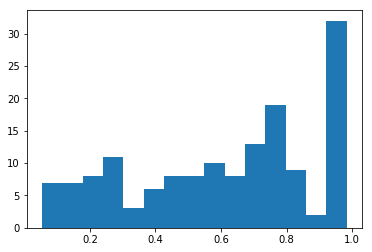

In [11]:
a = np.array(countries_data['Wiki Stability MLE'].values.tolist())
countries_data['Stability Truncated'] = np.where(a > 1.0, 1.0, a).tolist()
countries_data['stab to plot'] = np.power(countries_data['Stability Truncated'] * (1-countries_data['Wiki Instability old']), 2)
countries_data2 = countries_data.copy()
countries_data2.fillna(0, inplace=True)
val = countries_data2[(countries_data2['stab to plot'] > 0.0001 ) & (countries_data2['stab to plot'] < 0.999 ) ]['stab to plot'].values
val = np.array(val)
plt.hist(val, bins=15)
plt.show()

In [158]:
wiki_change_factor( 'Russia', 2013, 2017, outlier_factor=3.4)

0.11070588235294117

In [12]:
countries_data2 = countries_data[['Code', 'stab to plot']].copy()
countries_data2.fillna(0, inplace=True)

m = folium.Map(location=[30, -30],
                   tiles='Mapbox Bright', zoom_start=2.5)

m.geo_json(geo_path=r'data/countries.geo.json', data=countries_data2,
             columns=['Code', 'stab to plot'],
             key_on='feature.id',
             fill_color='YlGn', fill_opacity=0.5, line_opacity=0.1,
             legend_name='Data Rate ')


m.save()

#### Conclusions to Part II
1. We can see that usually smaller countries has more stable wikipedia --> less things are happening
2. We can observe that in Ukraine there were major changes, probably due to War
3. We can observe that in Spain there were major changes, probably due to Catalonia protest
3. High changes in Germany, Croatia or Lithuania are bizzare, this will be examined in further analysis with events
4. Greece is not being flaged by our index. This is not normal considering the difficulties the country encoutered in 2011

#### Plans
Make the same map for all countries around the world, not only for Europe. 

---
### Part III - Showing the limits

At the moment, our index only considers the main wikipedia page of a country. This is clearly a limitation as information is very coarse grain at this level. Indeed, we are loosing a lot of information on some smaller events that might be interesting to consider like for example the Paris terrorists attack in 2015.

In [ ]:
# Fetches France's wikipedia page history
france_history_fetcher = HistoryFetcher('France')
france_history = france_history_fetcher.get_history('20150101000000', '20160101000000')

france_edits_dates = list(map(lambda revision: revision['timestamp'], france_history))

In [ ]:
# Add historgram for the number of edits on Frances's wikipedia page
n_wiki, bins_wiki, patches_wiki = plt.hist(france_edits_dates,\
                                           bins=52,\
                                           color='blue',\
                                           alpha=0.5,\
                                           label='# of edits on France page')

# Add the two main terrorists attacks that happened in 2015 on the timeline
plt.scatter([dateutil.parser.parse('20150107'), dateutil.parser.parse('20151113')], [0, 0], label='Terrorist attacks')

plt.xticks(rotation=45)
plt.xlabel('Time (in weeks)')
plt.ylabel('# of edits')
plt.legend(loc='upper right')
plt.show()

First terror attack did not trigger any immediate change on the wikipedia page (remember that each bar correspond to one week). 

Second terror attack could have maybe increased the number of edits but the bump is too low and would be almost impossible to detect automaticaly.

This problem in the resolution of our information motivates one of our objectives for next milestone.

---
### Part IV - Plan for next milestone

As of part 1, we're planning to find more event like this or maybe even semi-automate the process, to check if some event had some effect on wikipedia change rate.

Our priority for next milestone will be to improve our event detector that was exposed in part 2. We will also improve the formula that computes the stability index.

Depending on the time left we will try to improve our countries description using multiple wikipedia pages instead of using only the main one. This will let us have a much better view on the impact of events on any country. 

In [5]:
def get_edits_dates_and_size(country, start, end):
    history_fetcher = HistoryFetcher(country)
    response = history_fetcher.get_history(start, end)
    
    edits_dates = list(map(lambda revision: (revision['timestamp'], np.log(abs(revision['change_size'])+1)), response))
    
    return edits_dates

(251, 14)

In [179]:
countries_data = pd.read_pickle('countries_data.pckl')

countries_data.head()

,Code numeric,FIPS,Code,Country,Region,Wiki Stability MLE,Wiki Instability old,Wiki mean change day,Population[k],Internet Users%,...,Perason Wiki/GDELT Events we,Perason Wiki/GDELT Events mo *sur,Perason Corr QuadClass1,Perason Corr QuadClass2,Perason Corr QuadClass3,Perason Corr QuadClass4,Pearson Corr QuadClass1,Pearson Corr QuadClass2,Pearson Corr QuadClass3,Pearson Corr QuadClass4
0,533.0,AA,ABW,Aruba,Americas,2.400000,0.023033,0.354108,105.264,88.6612,...,0.035040,0.002980,NaN,NaN,NaN,NaN,0.002634,0.014660,-0.022884,0.015593
1,28.0,AC,ATG,Antigua and Barbuda,Americas,3.303965,0.098758,0.257224,102.012,65.2,...,0.302105,0.244411,NaN,NaN,NaN,NaN,0.235806,0.274649,0.141033,0.255410
2,784.0,AE,ARE,United Arab Emirates,Asia,0.471846,0.036796,1.801133,9400.145,91.2434,...,NaN,0.023050,NaN,NaN,NaN,NaN,0.049526,-0.000536,-0.007324,0.000611
3,4.0,AF,AFG,Afghanistan,Asia,0.000000,0.000000,0.000000,35530.081,8.26,...,0.089826,0.150069,NaN,NaN,NaN,NaN,0.072509,0.187349,0.062449,0.260922
4,12.0,AG,DZA,Algeria,Africa,0.665484,0.100532,1.277054,41318.142,38.2,...,0.492696,0.512626,NaN,NaN,NaN,NaN,0.497177,0.524764,0.549691,0.517976


In [326]:
colors_eu = ['#fff7fb', '#ece2f0', '#d0d1e6', '#a6bddb', '#67a9cf', '#3690c0', '#02818a', '#016c59',  '#014636','#114636' ]
thresh_eu = [0.1      , 0.2      , 0.30      , 0.40     , 0.50     , 0.60     , 0.70     , 0.80, 0.90]


def wiki_changes_colors_eu(state):
    """Maps Unemplpoyment value with colors."""
    try:
        
        #instab = countries_data[countries_data['Code']==state]['Wiki Instability old'].values[0]
        #if(instab < 0.0001):
        #    return '#d9d9d9'
        #tab = countries_data[countries_data['Code']==state]['Wiki Stability MLE'].values[0]
        #if(tab > 200.0):
        #    return '#d9d9d9'
        
        val = countries_data[countries_data['Code']==state]['Perason Wiki/GDELT Events mo *sur'].values[0]

    except:
        #print('exception: ',state)
        return '#bdbdbd'
    
    if np.isnan(val):
        #print('nan: ',state)
        return '#bdbdbd'
    
    length = len(thresh_eu)
    for i in range(0, length-1):
        if val < thresh_eu[i]:
            return colors_eu[i]
    return  colors_eu[length-1]


m = make_folium_map('maps/world-countries-sans-antarctica.json', 'objects.countries1',
                    wiki_changes_colors_eu, 0.0, 100, colors_eu, 
                    [56,10], 2, '% Pearson wiki edits/gdelt events correlation')

m

In [165]:
codes = countries_data['Code'].values
countries = countries_data['Country'].values
regions = countries_data['Region'].values



cor_val = countries_data['Perason Wiki/GDELT Events mo *sur'].values

instab = countries_data['Wiki Instability old']

stab = countries_data['Wiki Stability MLE']

for i in range(len(codes)):
    if(instab[i] < 0.0002) | (stab[i] > 100.0):
        cor_val[i] = np.NaN
    
colors= {'Africa':'red','Europe':'green','Americas':'blue', 'Oceania':'yellow','Asia':'blue','':'grey'}

cor_val= np.array(cor_val)
countries = np.array(countries)

nans = np.isnan(cor_val)
countries = countries[~nans]
cor_val = cor_val[~nans]

cor_val, countries = (list(t) for t in zip(*sorted(zip(cor_val.astype(int), countries))))
cor_val = cor_val[-40:]
countries = countries[-40:]

plt.rcParams["figure.figsize"] = (16,8)

plt.bar(range(len(cor_val)), cor_val, align='center')

for i, val in enumerate(cor_val):
    state= countries_data[countries_data['Country'] == countries[i]]['Code'].values[0]
    plt.bar(i, val, align='center', color=wiki_changes_colors_eu(state))
plt.xticks(range(len(cor_val)), countries, rotation=90)
plt.ylabel('National Wikipedia Correlation with GDELT Events')
plt.title('Top 50 Countries wiki correlation with GDELT Events')
plt.show()

TypeError: unorderable types: float() < str()

In [333]:
colors_eu = ['#fff7fb', '#ece2f0', '#d0d1e6', '#a6bddb', '#67a9cf', '#3690c0', '#02818a', '#016c59',  '#014636','#114636' ]
thresh_eu = [0.05      , 0.1      , 0.15      , 0.2     , 0.25     , 0.3     , 0.35     , 0.4, 0.45]


def wiki_changes_colors_eu(state):
    """Maps Unemplpoyment value with colors."""
    try:
        
        #instab = countries_data[countries_data['Code']==state]['Wiki Instability old'].values[0]
        #if(instab < 0.0001):
        #    return '#d9d9d9'
        #tab = countries_data[countries_data['Code']==state]['Wiki Stability MLE'].values[0]
        #if(tab > 200.0):
        #    return '#d9d9d9'
        val = (countries_data[countries_data['Code']==state]['Pearson Corr QuadClass1'].values[0])
        val += (countries_data[countries_data['Code']==state]['Pearson Corr QuadClass2'].values[0])
        val += (countries_data[countries_data['Code']==state]['Pearson Corr QuadClass3'].values[0])
        val += (countries_data[countries_data['Code']==state]['Pearson Corr QuadClass4'].values[0])
        val = np.abs(val)/4

    except:
        #print('exception: ',state)
        return '#bdbdbd'
    
    if np.isnan(val):
        #print('nan: ',state)
        return '#bdbdbd'
    
    length = len(thresh_eu)
    for i in range(0, length-1):
        if val < thresh_eu[i]:
            return colors_eu[i]
    return  colors_eu[length-1]


m = make_folium_map('maps/world-countries-sans-antarctica.json', 'objects.countries1',
                    wiki_changes_colors_eu, 0.0, 50, colors_eu, 
                    [56,10], 1.9, '% Pearson wiki edits/gdelt events correlation')

m

In [328]:
countries_data[countries_data['Country']=='Norway']

,Code numeric,FIPS,Code,Country,Region,Wiki Stability MLE,Wiki Instability old,Wiki mean change day,Population[k],Internet Users%,...,Big Internet,GDP,GDP per capita,Stability Truncated,Perason Wiki/GDELT Events we,Perason Wiki/GDELT Events mo *sur,Pearson Corr QuadClass1,Pearson Corr QuadClass2,Pearson Corr QuadClass3,Pearson Corr QuadClass4
